In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa as tsa
import statsmodels as sm
from datetime import datetime
import os
from pathlib import Path
from PIL import Image
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from concurrent.futures import ThreadPoolExecutor
import torch
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import transforms

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando dispositivo:", device)

Usando dispositivo: cuda


# Descargar el dataset

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("agungpambudi/mnist-multiple-dataset-comprehensive-analysis")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/mnist-multiple-dataset-comprehensive-analysis


# Dos CNN con capas diferentes

In [ ]:
transform = transforms.Compose([
    transforms.Resize((28,28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

class ModuleDataset(Dataset):
    def __init__(self, module_dir, transform=None):
        self.module_dir = Path(module_dir)
        self.files = sorted(self.module_dir.glob("*.png"),
                            key=lambda p: int(p.stem.split(".")[0]))
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        p = self.files[idx]
        label = int(p.stem.split(".")[1])
        img = Image.open(p).convert("L")
        if self.transform:
            img = self.transform(img)
        return img, label

In [ ]:
from pathlib import Path
base = Path("/kaggle/input/mnist-multiple-dataset-comprehensive-analysis")

# Lista directos de primer nivel
print("Contenido de versions/3:", sorted(p.name for p in base.iterdir()))

# Si no ves 'MMNIST' directamente, busca recursivamente:
for p in base.rglob("MMNIST"):
    print("Encontrado MMNIST en:", p)
    break;

Contenido de versions/3: ['MNIST-MIX-all', 'PolyMNIST', 'README.md', 'label.csv', 'label.json', 'model.pth']
Encontrado MMNIST en: /kaggle/input/mnist-multiple-dataset-comprehensive-analysis/PolyMNIST/MMNIST


In [ ]:
data_root = "/kaggle/input/mnist-multiple-dataset-comprehensive-analysis/PolyMNIST/MMNIST"
train_dir = Path(data_root) / "train"
test_dir  = Path(data_root) / "test"
modules   = ["m0","m1","m2","m3","m4"]

In [ ]:
train_datasets = [ModuleDataset(train_dir/m, transform) for m in modules]
test_datasets  = [ModuleDataset(test_dir /m, transform) for m in modules]

full_train_ds = ConcatDataset(train_datasets)
full_test_ds  = ConcatDataset(test_datasets)

full_train_loader = DataLoader(full_train_ds, batch_size=64, shuffle=True,  num_workers=2)
full_test_loader  = DataLoader(full_test_ds,  batch_size=64, shuffle=False, num_workers=2)

In [ ]:
def full_dataset(loader):
    xs, ys = [], []
    for xb, yb in loader:
        xs.append(xb)
        ys.append(yb)
    X = torch.cat(xs, dim=0)
    y = torch.cat(ys, dim=0)
    return X, y

In [ ]:
x_train, y_train = full_dataset(full_train_loader)
x_test,  y_test  = full_dataset(full_test_loader)

In [ ]:
print("x_train:", x_train.shape, "y_train:", y_train.shape)
print("x_test: ",  x_test.shape,  "y_test:",  y_test.shape)

x_train: torch.Size([300000, 1, 28, 28]) y_train: torch.Size([300000])
x_test:  torch.Size([50000, 1, 28, 28]) y_test: torch.Size([50000])


In [ ]:
print(x_train, x_train.size)

tensor([[[[ 0.4431,  0.4431,  0.4745,  ...,  0.6392,  0.6157,  0.5843],
          [ 0.4196,  0.4588,  0.4667,  ...,  0.5843,  0.6000,  0.5765],
          [ 0.4039,  0.4745,  0.4824,  ...,  0.5216,  0.5137,  0.4510],
          ...,
          [ 0.4588,  0.5686,  0.6235,  ...,  0.2392,  0.4431,  0.4275],
          [ 0.4510,  0.5451,  0.6235,  ...,  0.4118,  0.4588,  0.4275],
          [ 0.4353,  0.5294,  0.6235,  ...,  0.3882,  0.3804,  0.4039]]],


        [[[-0.1373, -0.2706, -0.3020,  ..., -0.1529, -0.2235, -0.5922],
          [-0.2392, -0.3647, -0.4667,  ...,  0.0353, -0.1686, -0.5765],
          [-0.3176, -0.4980, -0.6157,  ...,  0.1843, -0.1529, -0.5451],
          ...,
          [-0.8196, -0.7961, -0.7804,  ...,  0.8431,  0.4118, -0.2627],
          [-0.4824, -0.5294, -0.6549,  ...,  0.7412,  0.3176, -0.2941],
          [ 0.2706,  0.0353, -0.3255,  ...,  0.0431, -0.0510, -0.2863]]],


        [[[-0.8275, -0.7961, -0.7804,  ..., -0.8118, -0.7961, -0.6000],
          [-0.8118, -0.803

In [ ]:
print(y_test, y_test.shape)

tensor([8, 0, 5,  ..., 1, 1, 1]) torch.Size([50000])


In [ ]:
y_test[0]

tensor(8)

# Dos Modelos CNN

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
class CNNModelA(nn.Module):
    """
    Modelo CNN básico de 3 bloques conv-pool:
      - Conv 32 filtros, kernel 3
      - Conv 64 filtros, kernel 3
      - Conv 128 filtros, kernel 3
      - Pooling 2×2 tras cada par de convs
      - Fully‑connected a 256 → salida 10
    """
    def __init__(self, num_classes: int = 10):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.fc1   = nn.Linear(128 * 7 * 7, 256)
        self.fc2   = nn.Linear(256, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)

        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
class CNNModelB(nn.Module):
    """
    Modelo CNN con batch norm y dropout:
      - Conv 64 filtros, kernel 5
      - Conv 64 filtros, kernel 5
      - Pooling 2×2
      - Conv 128 filtros, kernel 3
      - Conv 128 filtros, kernel 3
      - Pooling 2×2
      - Dropout y fully‑connected
    """
    def __init__(self, num_classes: int = 10, dropout_p: float = 0.5):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=5, padding=2)
        self.bn1   = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=5, padding=2)
        self.bn2   = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3   = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn4   = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.dropout = nn.Dropout(dropout_p)
        self.fc1     = nn.Linear(128 * 7 * 7, 512)
        self.fc2     = nn.Linear(512, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)

        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)

        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [22]:
from torch import nn, optim
from typing import Dict, Any

def evaluate_models(models: Dict[str, nn.Module],
                    loader: torch.utils.data.DataLoader,
                    device: torch.device) -> Dict[str, Dict[str, float]]:
    """
    Evalúa varios modelos sobre un DataLoader:
      - models: dict de nombre->modelo
      - loader: DataLoader de test/validación
      - device: torch.device
    Devuelve: { nombre: {"loss": ..., "accuracy": ...}, … }
    """
    criterion = nn.CrossEntropyLoss()
    results = {}
    for name, model in models.items():
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for x, y in loader:
                x = x.to(device, non_blocking=True)
                y = y.to(device, non_blocking=True)
                logits = model(x)
                loss = criterion(logits, y)
                running_loss += loss.item() * x.size(0)
                preds = logits.argmax(dim=1)
                correct += (preds == y).sum().item()
                total += x.size(0)
        avg_loss = running_loss / total
        acc = correct / total
        results[name] = {"loss": avg_loss, "accuracy": acc}
    return results

def train_and_evaluate_with_history(model: nn.Module,
                                    train_loader: torch.utils.data.DataLoader,
                                    test_loader: torch.utils.data.DataLoader,
                                    device: torch.device,
                                    epochs: int = 5,
                                    lr: float = 1e-3,
                                    name: str = "Model") -> Dict[str, Any]:
    """
    Entrena el modelo y al final de cada epoch evalúa usando evaluate_models.
    Devuelve un history dict con listas: train_loss, train_acc, test_loss, test_acc.
    """
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    history = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    for epoch in range(1, epochs + 1):
        # --- Training ---
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for x_batch, y_batch in train_loader:
            x_batch = x_batch.to(device, non_blocking=True)
            y_batch = y_batch.to(device, non_blocking=True)

            optimizer.zero_grad()
            logits = model(x_batch)
            loss = criterion(logits, y_batch)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * x_batch.size(0)
            preds = logits.argmax(dim=1)
            correct += (preds == y_batch).sum().item()
            total += x_batch.size(0)

        avg_train_loss = running_loss / total
        train_acc = correct / total * 100

        # --- Testing ---
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for x_batch, y_batch in test_loader:
                x_batch = x_batch.to(device, non_blocking=True)
                y_batch = y_batch.to(device, non_blocking=True)

                logits = model(x_batch)
                loss = criterion(logits, y_batch)

                running_loss += loss.item() * x_batch.size(0)
                preds = logits.argmax(dim=1)
                correct += (preds == y_batch).sum().item()
                total += x_batch.size(0)

        test_loss = running_loss / total
        test_acc  = correct / total * 100

        print(f"Epoch {epoch}/{epochs} - "
              f"Train Loss: {avg_train_loss:.4f} - Train Acc: {train_acc:.2f}% - "
              f"Test Loss: {test_loss:.4f} - Test Acc: {test_acc:.2f}%")

        history["train_loss"].append(avg_train_loss)
        history["train_acc"].append(train_acc)
        history["test_loss"].append(test_loss)
        history["test_acc"].append(test_acc)

    return history, test_loss, test_acc

In [ ]:
print("Entrenamiento Modelo CNN 3 bloques")
model_a = CNNModelA()
history_a, test_loss_a, test_acc_a = train_and_evaluate_with_history(model_a, full_train_loader, full_test_loader, device)

Entrenamiento Modelo CNN 3 bloques
Epoch 1/5 - Train Loss: 0.1501 - Train Acc: 95.11% - Test Loss: 0.0683 - Test Acc: 97.79%
Epoch 2/5 - Train Loss: 0.0453 - Train Acc: 98.52% - Test Loss: 0.0589 - Test Acc: 98.30%
Epoch 3/5 - Train Loss: 0.0280 - Train Acc: 99.07% - Test Loss: 0.0652 - Test Acc: 98.11%
Epoch 4/5 - Train Loss: 0.0206 - Train Acc: 99.30% - Test Loss: 0.0686 - Test Acc: 98.16%
Epoch 5/5 - Train Loss: 0.0165 - Train Acc: 99.44% - Test Loss: 0.0833 - Test Acc: 98.30%


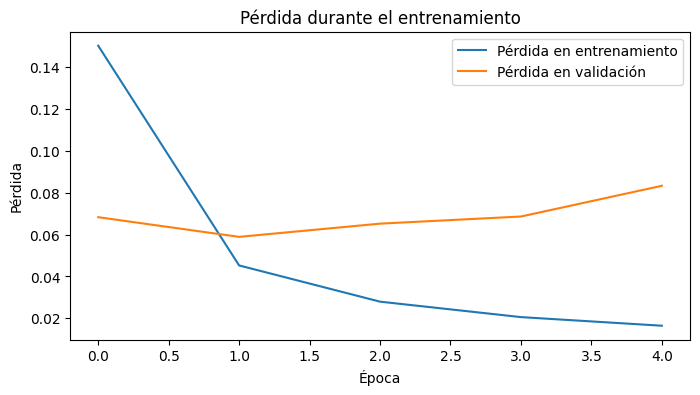

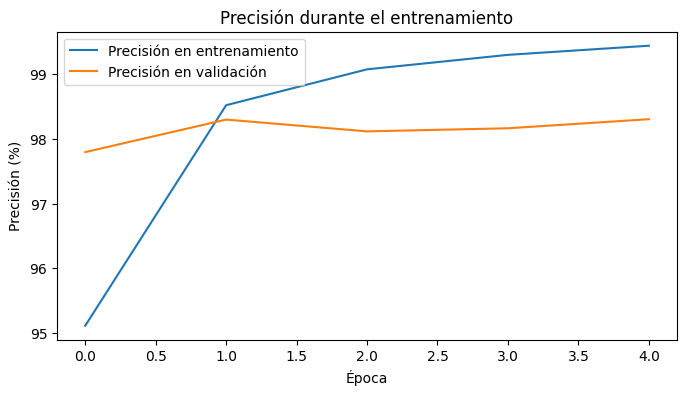

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot(history_a['train_loss'], label='Pérdida en entrenamiento')
plt.plot(history_a['test_loss'],  label='Pérdida en validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.title('Pérdida durante el entrenamiento')
plt.legend()
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(history_a['train_acc'], label='Precisión en entrenamiento')
plt.plot(history_a['test_acc'],  label='Precisión en validación')
plt.xlabel('Época')
plt.ylabel('Precisión (%)')
plt.title('Precisión durante el entrenamiento')
plt.legend()
plt.show()

In [ ]:
print("Entrenamiento Modelo CNN 5 kernel")
model_b = CNNModelB()
history_b, test_loss_b, test_acc_b = train_and_evaluate_with_history(model_b, full_train_loader, full_test_loader, device)

Entrenamiento Modelo CNN 5 kernel
Epoch 1/5 - Train Loss: 0.2714 - Train Acc: 91.50% - Test Loss: 0.0895 - Test Acc: 97.17%
Epoch 2/5 - Train Loss: 0.1229 - Train Acc: 96.30% - Test Loss: 0.0606 - Test Acc: 98.07%
Epoch 3/5 - Train Loss: 0.0900 - Train Acc: 97.28% - Test Loss: 0.0563 - Test Acc: 98.21%
Epoch 4/5 - Train Loss: 0.0719 - Train Acc: 97.78% - Test Loss: 0.0514 - Test Acc: 98.34%
Epoch 5/5 - Train Loss: 0.0619 - Train Acc: 98.09% - Test Loss: 0.0522 - Test Acc: 98.47%


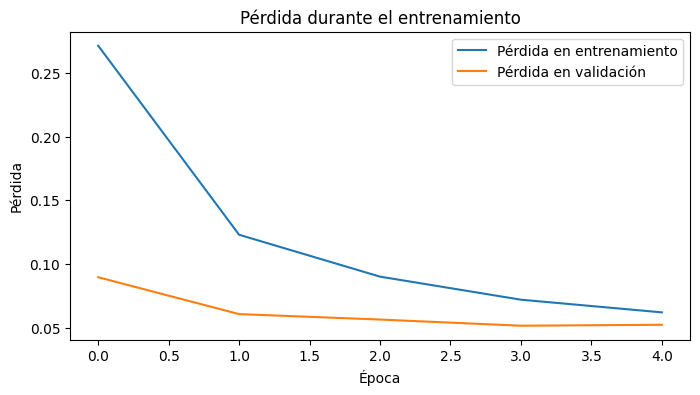

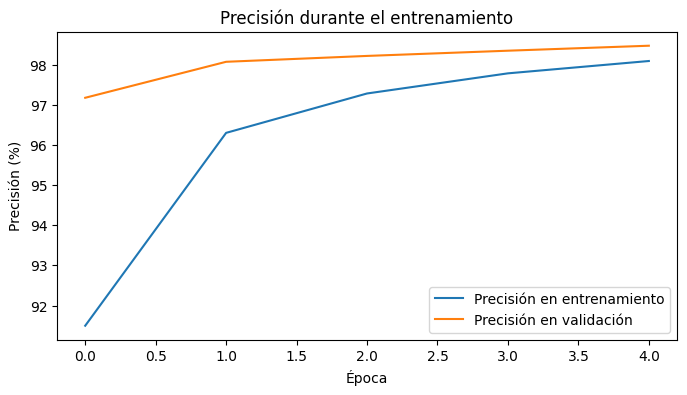

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(history_b['train_loss'], label='Pérdida en entrenamiento')
plt.plot(history_b['test_loss'],  label='Pérdida en validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.title('Pérdida durante el entrenamiento')
plt.legend()
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(history_b['train_acc'], label='Precisión en entrenamiento')
plt.plot(history_b['test_acc'],  label='Precisión en validación')
plt.xlabel('Época')
plt.ylabel('Precisión (%)')
plt.title('Precisión durante el entrenamiento')
plt.legend()
plt.show()

In [ ]:
if test_acc_a > test_acc_b:
    print("Mejor modelo: Modelo CNN 3 bloques")
else:
    print("Mejor modelo: Modelo CNN 5 kernel")

Mejor modelo: Modelo CNN 5 kernel


En conclusión, el modelo con 5 kernels —gracias a sus filtros iniciales más grandes (5×5), la normalización por lotes tras cada convolución y la incorporación de dropout— logra una validación más estable y una menor brecha con respecto al entrenamiento, traduciéndose en una pérdida de validación más baja y una precisión final superior. Estas mejoras en la arquitectura fortalecen su capacidad de extraer características relevantes sin sobreajustarse, garantizando así una mejor generalización sobre datos desconocidos.


# Modelo CNN FULLY CONNECTED

In [ ]:
class FullyConnectedModel(nn.Module):
    """
    MLP para imágenes 28×28 en escala de grises:
      - Flatten (784)
      - Linear → 512 → ReLU → Dropout(0.5)
      - Linear → 256 → ReLU → Dropout(0.5)
      - Linear → num_classes
    """
    def __init__(self, num_classes: int = 10, dropout_p: float = 0.5):
        super().__init__()
        self.fc1 = nn.Linear(28 * 28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [ ]:
print("Entrenamiento Modelo CNN Fully connected")
model_FC = FullyConnectedModel()
history_FC, test_loss_FC, test_acc_FC = train_and_evaluate_with_history(model_FC, full_train_loader, full_test_loader, device)

Entrenamiento Modelo CNN Fully connected
Epoch 1/5 - Train Loss: 1.0430 - Train Acc: 67.32% - Test Loss: 0.6810 - Test Acc: 79.57%
Epoch 2/5 - Train Loss: 0.8368 - Train Acc: 73.66% - Test Loss: 0.5994 - Test Acc: 81.80%
Epoch 3/5 - Train Loss: 0.7756 - Train Acc: 75.39% - Test Loss: 0.5601 - Test Acc: 83.08%
Epoch 4/5 - Train Loss: 0.7372 - Train Acc: 76.69% - Test Loss: 0.5378 - Test Acc: 84.15%
Epoch 5/5 - Train Loss: 0.7148 - Train Acc: 77.41% - Test Loss: 0.5222 - Test Acc: 84.59%


In [ ]:
print("Efectividad: " + str(test_acc_FC))
print("Perdida: " + str(test_loss_FC))

Efectividad: 84.588
Perdida: 0.5222148655414581


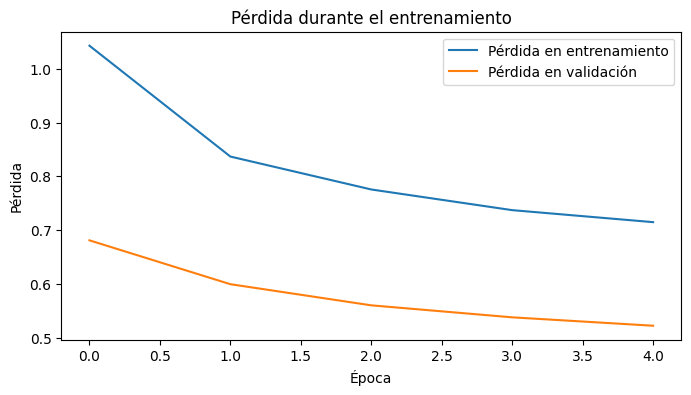

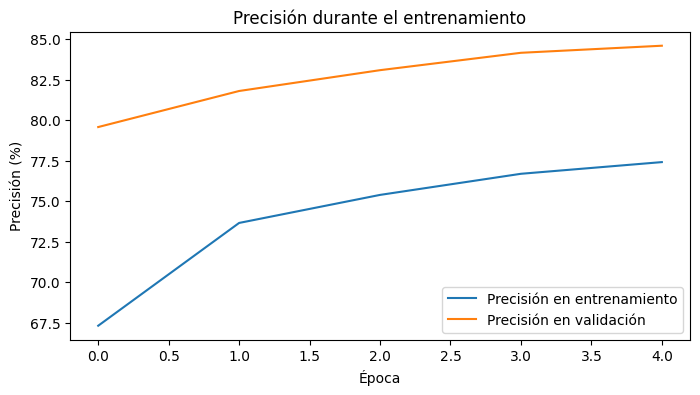

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(history_FC['train_loss'], label='Pérdida en entrenamiento')
plt.plot(history_FC['test_loss'],  label='Pérdida en validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.title('Pérdida durante el entrenamiento')
plt.legend()
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(history_FC['train_acc'], label='Precisión en entrenamiento')
plt.plot(history_FC['test_acc'],  label='Precisión en validación')
plt.xlabel('Época')
plt.ylabel('Precisión (%)')
plt.title('Precisión durante el entrenamiento')
plt.legend()
plt.show()

El modelo fully connected alcanzó una precisión de validación del **84,6 %** con una pérdida de **0,52**, mostrando curvas de pérdida decrecientes tanto en entrenamiento como en validación y una brecha moderada entre ambas, lo que indica que aprende sin sobreajustarse excesivamente; sin embargo, su capacidad de capturar la estructura espacial de las imágenes es limitada frente a redes convolucionales, por lo que, pese a comportarse de forma estable, su efectividad se sitúa en un nivel medio y podría mejorarse.


## Otro Algoritmo Modelo LeNet-5
LeNet‑5 es una CNN con alternancia de capas convolucionales (para extraer patrones locales como bordes y trazos) y submuestreo/pooling (para ganar invariancia a traslaciones pequeñas y reducir ruido), seguida de capas totalmente conectadas que hacen la decisión final de clase.



In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class LeNet5(nn.Module):
    """
    LeNet-5 model architecture for image classification.
    Based on http://yann.lecun.com/exdb/mnist/
    """
    def __init__(self, num_classes: int = 10):
        super().__init__()
        # C1: 6 output channels, 5x5 kernel, stride 1, padding 2 to maintain size for S2
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2)
        # S2: 2x2 kernel, stride 2
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)

        # C3: 16 output channels, 5x5 kernel, stride 1
        # Padding is not explicitly mentioned in the original paper for C3,
        # but we will use padding=0 as it is standard. The input to C3
        # comes from S2 which is 14x14, and 5x5 kernel without padding results in 10x10.
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0)
        # S4: 2x2 kernel, stride 2
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)

        # C5: 120 output channels. This layer is fully connected in the original paper,
        # but implemented as a convolutional layer for efficiency.
        # The input to C5 comes from S4 which is 5x5. A 5x5 kernel results in 1x1 output.
        self.conv3 = nn.Conv2d(16, 120, kernel_size=5, stride=1, padding=0)

        # F6: 84 output units
        self.fc1 = nn.Linear(120, 84)
        # Output layer: 10 output units for 10 classes
        self.fc2 = nn.Linear(84, num_classes)


    def forward(self, x):
        # C1 -> ReLU -> S2
        x = self.pool1(F.relu(self.conv1(x)))
        # C3 -> ReLU -> S4
        x = self.pool2(F.relu(self.conv2(x)))
        # C5 -> ReLU
        x = F.relu(self.conv3(x))

        # Flatten for F6
        x = x.view(x.size(0), -1)

        # F6 -> ReLU
        x = F.relu(self.fc1(x))
        # Output layer
        x = self.fc2(x)
        return x

print("LeNet-5 model defined.")

LeNet-5 model defined.


Entrenamiento



In [ ]:
import torch
from torch import nn, optim
from typing import Dict, Any
from pathlib import Path
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import kagglehub

# Download latest version
path = kagglehub.dataset_download("agungpambudi/mnist-multiple-dataset-comprehensive-analysis")

print("Path to dataset files:", path)


# Define the transform
transform = transforms.Compose([
    transforms.Resize((28,28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Define the ModuleDataset class
class ModuleDataset(Dataset):
    def __init__(self, module_dir, transform=None):
        self.module_dir = Path(module_dir)
        self.files = sorted(self.module_dir.glob("*.png"),
                            key=lambda p: int(p.stem.split(".")[0]))
        self.transform = transform
        print(f"Found {len(self.files)} files in {self.module_dir}")


    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        p = self.files[idx]
        label = int(p.stem.split(".")[1])
        img = Image.open(p).convert("L")
        if self.transform:
            img = self.transform(img)
        return img, label

# Define the data paths and modules
data_root = "/kaggle/input/mnist-multiple-dataset-comprehensive-analysis/PolyMNIST/MMNIST"
train_dir = Path(data_root) / "train"
test_dir  = Path(data_root) / "test"
modules   = ["m0","m1","m2","m3","m4"]

# Create the datasets and data loaders
train_datasets = [ModuleDataset(train_dir/m, transform) for m in modules]
test_datasets  = [ModuleDataset(test_dir /m, transform) for m in modules]

full_train_ds = ConcatDataset(train_datasets)
full_test_ds  = ConcatDataset(test_datasets)

full_train_loader = DataLoader(full_train_ds, batch_size=64, shuffle=True,  num_workers=2)
full_test_loader  = DataLoader(full_test_ds,  batch_size=64, shuffle=False, num_workers=2)


def evaluate_models(models: Dict[str, nn.Module],
                    loader: torch.utils.data.DataLoader,
                    device: torch.device) -> Dict[str, Dict[str, float]]:
    """
    Evalúa varios modelos sobre un DataLoader:
      - models: dict de nombre->modelo
      - loader: DataLoader de test/validación
      - device: torch.device
    Devuelve: { nombre: {"loss": ..., "accuracy": ...}, … }
    """
    criterion = nn.CrossEntropyLoss()
    results = {}
    for name, model in models.items():
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for x, y in loader:
                x = x.to(device, non_blocking=True)
                y = y.to(device, non_blocking=True)
                logits = model(x)
                loss = criterion(logits, y)
                running_loss += loss.item() * x.size(0)
                preds = logits.argmax(dim=1)
                correct += (preds == y).sum().item()
                total += x.size(0)
        avg_loss = running_loss / total
        acc = correct / total
        results[name] = {"loss": avg_loss, "accuracy": acc}
    return results

def train_and_evaluate_with_history(model: nn.Module,
                                    train_loader: torch.utils.data.DataLoader,
                                    test_loader: torch.utils.data.DataLoader,
                                    device: torch.device,
                                    epochs: int = 5,
                                    lr: float = 1e-3,
                                    name: str = "Model") -> Dict[str, Any]:
    """
    Entrena el modelo y al final de cada epoch evalúa usando evaluate_models.
    Devuelve un history dict con listas: train_loss, train_acc, test_loss, test_acc.
    """
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    history = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    for epoch in range(1, epochs + 1):
        # --- Training ---
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for x_batch, y_batch in train_loader:
            x_batch = x_batch.to(device, non_blocking=True)
            y_batch = y_batch.to(device, non_blocking=True)

            optimizer.zero_grad()
            logits = model(x_batch)
            loss = criterion(logits, y_batch)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * x_batch.size(0)
            preds = logits.argmax(dim=1)
            correct += (preds == y_batch).sum().item()
            total += x_batch.size(0)

        avg_train_loss = running_loss / total
        train_acc = correct / total * 100

        # --- Testing ---
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for x_batch, y_batch in test_loader:
                x_batch = x_batch.to(device, non_blocking=True)
                y_batch = y_batch.to(device, non_blocking=True)

                logits = model(x_batch)
                loss = criterion(logits, y_batch)

                running_loss += loss.item() * x_batch.size(0)
                preds = logits.argmax(dim=1)
                correct += (preds == y_batch).sum().item()
                total += x_batch.size(0)

        test_loss = running_loss / total
        test_acc  = correct / total * 100

        print(f"Epoch {epoch}/{epochs} - "
              f"Train Loss: {avg_train_loss:.4f} - Train Acc: {train_acc:.2f}% - "
              f"Test Loss: {test_loss:.4f} - Test Acc: {test_acc:.2f}%")

        history["train_loss"].append(avg_train_loss)
        history["train_acc"].append(train_acc)
        history["test_loss"].append(test_acc)

    return history, test_loss, test_acc


print("Entrenamiento Modelo LeNet-5")
model_LeNet5 = LeNet5()
history_LeNet5, test_loss_LeNet5, test_acc_LeNet5 = train_and_evaluate_with_history(model_LeNet5, full_train_loader, full_test_loader, device, epochs=10)

Usando dispositivo: cuda
Path to dataset files: /kaggle/input/mnist-multiple-dataset-comprehensive-analysis
Found 60000 files in /kaggle/input/mnist-multiple-dataset-comprehensive-analysis/PolyMNIST/MMNIST/train/m0
Found 60000 files in /kaggle/input/mnist-multiple-dataset-comprehensive-analysis/PolyMNIST/MMNIST/train/m1
Found 60000 files in /kaggle/input/mnist-multiple-dataset-comprehensive-analysis/PolyMNIST/MMNIST/train/m2
Found 60000 files in /kaggle/input/mnist-multiple-dataset-comprehensive-analysis/PolyMNIST/MMNIST/train/m3
Found 60000 files in /kaggle/input/mnist-multiple-dataset-comprehensive-analysis/PolyMNIST/MMNIST/train/m4
Found 10000 files in /kaggle/input/mnist-multiple-dataset-comprehensive-analysis/PolyMNIST/MMNIST/test/m0
Found 10000 files in /kaggle/input/mnist-multiple-dataset-comprehensive-analysis/PolyMNIST/MMNIST/test/m1
Found 10000 files in /kaggle/input/mnist-multiple-dataset-comprehensive-analysis/PolyMNIST/MMNIST/test/m2
Found 10000 files in /kaggle/input/mnis

# Transformaciones de imagenes


Este bloque define una serie de transformaciones de aumento de datos para el conjunto de entrenamiento de PolyMNIST, aplicando rotaciones aleatorias de hasta 15°, traslaciones de hasta un 10% y deformaciones por cizallamiento (shear) para simular variaciones comunes en dígitos escritos a mano y hacer al modelo más robusto. Luego convierte las imágenes a tensores normalizados en el rango [-1,1]. Finalmente, concatena los datos de las cinco modalidades en un único conjunto de entrenamiento con estas transformaciones aplicadas, mientras que el conjunto de prueba se mantiene sin cambios para evaluar el rendimiento real del modelo.









Preguntar a ChatGPT


In [ ]:
from torchvision import transforms

augmentation_transform = transforms.Compose([
    transforms.RandomRotation(degrees=15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), shear=10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

print("Data augmentation transformations defined.")

Data augmentation transformations defined.


## Creando dataset aumentados

In [ ]:
augmented_train_datasets = [ModuleDataset(train_dir/m, augmentation_transform) for m in modules]
augmented_full_train_ds = ConcatDataset(augmented_train_datasets)

augmented_train_loader = DataLoader(augmented_full_train_ds, batch_size=64, shuffle=True,  num_workers=2)
original_test_loader  = DataLoader(full_test_ds,  batch_size=64, shuffle=False, num_workers=2)

print("Augmented training loader and original test loader created.")

Found 60000 files in /kaggle/input/mnist-multiple-dataset-comprehensive-analysis/PolyMNIST/MMNIST/train/m0
Found 60000 files in /kaggle/input/mnist-multiple-dataset-comprehensive-analysis/PolyMNIST/MMNIST/train/m1
Found 60000 files in /kaggle/input/mnist-multiple-dataset-comprehensive-analysis/PolyMNIST/MMNIST/train/m2
Found 60000 files in /kaggle/input/mnist-multiple-dataset-comprehensive-analysis/PolyMNIST/MMNIST/train/m3
Found 60000 files in /kaggle/input/mnist-multiple-dataset-comprehensive-analysis/PolyMNIST/MMNIST/train/m4
Augmented training loader and original test loader created.


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class CNNModelA(nn.Module):
    """
    Modelo CNN básico de 3 bloques conv-pool:
      - Conv 32 filtros, kernel 3
      - Conv 64 filtros, kernel 3
      - Conv 128 filtros, kernel 3
      - Pooling 2×2 tras cada par de convs
      - Fully‑connected a 256 → salida 10
    """
    def __init__(self, num_classes: int = 10):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.fc1   = nn.Linear(128 * 7 * 7, 256)
        self.fc2   = nn.Linear(256, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)

        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class CNNModelB(nn.Module):
    """
    Modelo CNN con batch norm y dropout:
      - Conv 64 filtros, kernel 5
      - Conv 64 filtros, kernel 5
      - Pooling 2×2
      - Conv 128 filtros, kernel 3
      - Conv 128 filtros, kernel 3
      - Pooling 2×2
      - Dropout y fully‑connected
    """
    def __init__(self, num_classes: int = 10, dropout_p: float = 0.5):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=5, padding=2)
        self.bn1   = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=5, padding=2)
        self.bn2   = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3   = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn4   = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.dropout = nn.Dropout(dropout_p)
        self.fc1     = nn.Linear(128 * 7 * 7, 512)
        self.fc2     = nn.Linear(512, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)

        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)

        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

class FullyConnectedModel(nn.Module):
    """
    MLP para imágenes 28×28 en escala de grises:
      - Flatten (784)
      - Linear → 512 → ReLU → Dropout(0.5)
      - Linear → 256 → ReLU → Dropout(0.5)
      - Linear → num_classes
    """
    def __init__(self, num_classes: int = 10, dropout_p: float = 0.5):
        super().__init__()
        self.fc1 = nn.Linear(28 * 28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

print("Entrenamiento Modelo CNN 3 bloques con datos aumentados")
model_a_aug = CNNModelA()
history_a_aug, test_loss_a_aug, test_acc_a_aug = train_and_evaluate_with_history(model_a_aug, augmented_train_loader, original_test_loader, device)

print("\nEntrenamiento Modelo CNN 5 kernel con datos aumentados")
model_b_aug = CNNModelB()
history_b_aug, test_loss_b_aug, test_acc_b_aug = train_and_evaluate_with_history(model_b_aug, augmented_train_loader, original_test_loader, device)

print("\nEntrenamiento Modelo CNN Fully connected con datos aumentados")
model_FC_aug = FullyConnectedModel()
history_FC_aug, test_loss_FC_aug, test_acc_FC_aug = train_and_evaluate_with_history(model_FC_aug, augmented_train_loader, original_test_loader, device)

Entrenamiento Modelo CNN 3 bloques con datos aumentados
Epoch 1/5 - Train Loss: 0.3620 - Train Acc: 88.03% - Test Loss: 0.0850 - Test Acc: 97.20%
Epoch 2/5 - Train Loss: 0.1413 - Train Acc: 95.38% - Test Loss: 0.0696 - Test Acc: 97.69%
Epoch 3/5 - Train Loss: 0.1142 - Train Acc: 96.28% - Test Loss: 0.0586 - Test Acc: 98.16%
Epoch 4/5 - Train Loss: 0.1012 - Train Acc: 96.71% - Test Loss: 0.0519 - Test Acc: 98.28%
Epoch 5/5 - Train Loss: 0.0939 - Train Acc: 96.97% - Test Loss: 0.0543 - Test Acc: 98.27%

Entrenamiento Modelo CNN 5 kernel con datos aumentados
Epoch 1/5 - Train Loss: 0.6526 - Train Acc: 78.66% - Test Loss: 0.1087 - Test Acc: 96.54%
Epoch 2/5 - Train Loss: 0.3054 - Train Acc: 90.74% - Test Loss: 0.0933 - Test Acc: 97.09%
Epoch 3/5 - Train Loss: 0.2238 - Train Acc: 93.25% - Test Loss: 0.0634 - Test Acc: 97.98%
Epoch 4/5 - Train Loss: 0.1857 - Train Acc: 94.40% - Test Loss: 0.0651 - Test Acc: 97.89%
Epoch 5/5 - Train Loss: 0.1632 - Train Acc: 95.09% - Test Loss: 0.0584 - Test 

## Evaluando modelos


In [ ]:
retrained_models = {
    "CNNModelA_Augmented": model_a_aug,
    "CNNModelB_Augmented": model_b_aug,
    "FullyConnected_Augmented": model_FC_aug
}

evaluation_results_augmented = evaluate_models(retrained_models, original_test_loader, device)

for name, metrics in evaluation_results_augmented.items():
    print(f"{name}: Test Loss = {metrics['loss']:.4f}, Test Accuracy = {metrics['accuracy']:.4f}")

CNNModelA_Augmented: Test Loss = 0.0543, Test Accuracy = 0.9827
CNNModelB_Augmented: Test Loss = 0.0584, Test Accuracy = 0.9811
FullyConnected_Augmented: Test Loss = 0.9961, Test Accuracy = 0.7308


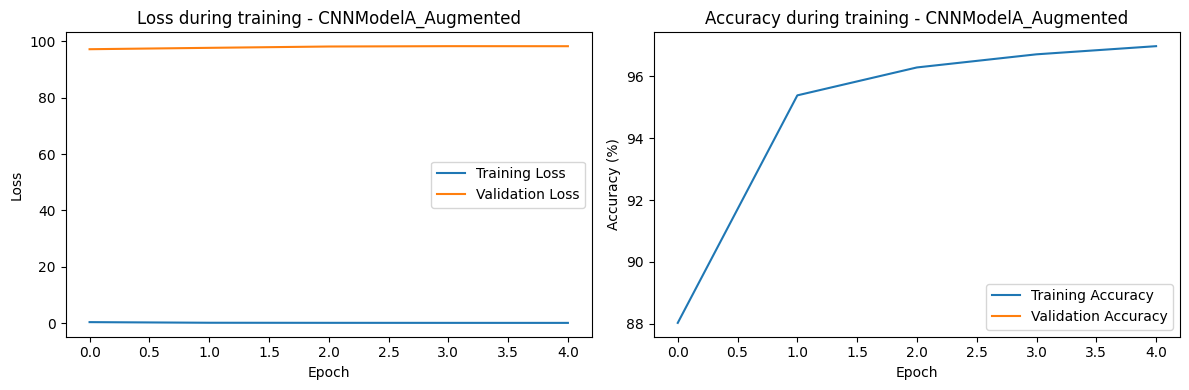

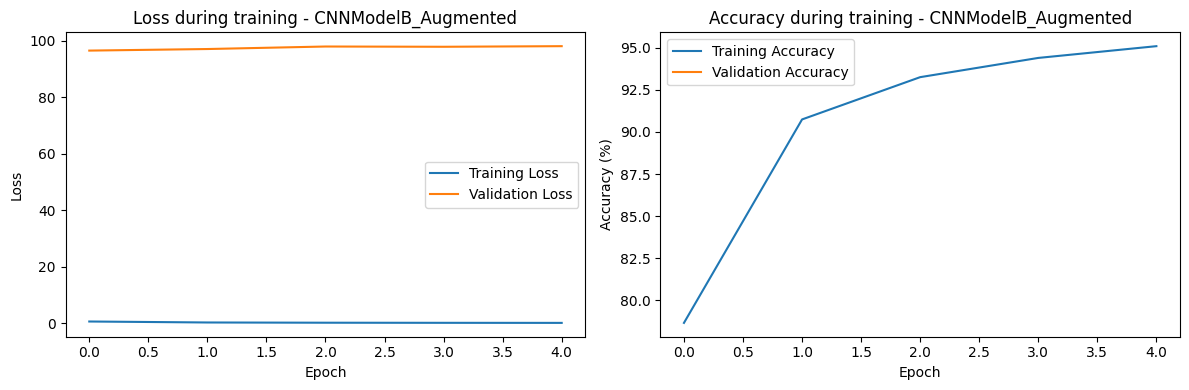

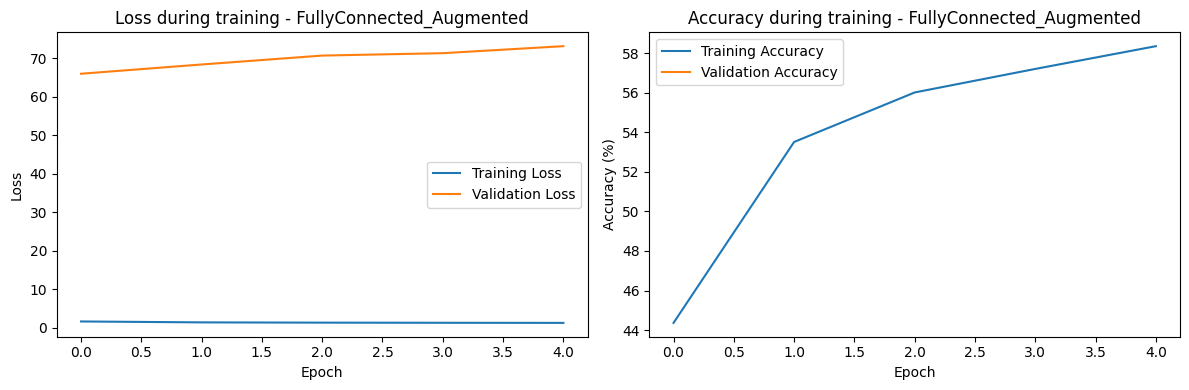

In [ ]:
import matplotlib.pyplot as plt

# Plot history for CNNModelA_Augmented
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_a_aug['train_loss'], label='Training Loss')
plt.plot(history_a_aug['test_loss'],  label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss during training - CNNModelA_Augmented')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_a_aug['train_acc'], label='Training Accuracy')
plt.plot(history_a_aug['test_acc'],  label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy during training - CNNModelA_Augmented')
plt.legend()

plt.tight_layout()
plt.show()

# Plot history for CNNModelB_Augmented
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_b_aug['train_loss'], label='Training Loss')
plt.plot(history_b_aug['test_loss'],  label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss during training - CNNModelB_Augmented')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_b_aug['train_acc'], label='Training Accuracy')
plt.plot(history_b_aug['test_acc'],  label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy during training - CNNModelB_Augmented')
plt.legend()

plt.tight_layout()
plt.show()

# Plot history for FullyConnected_Augmented
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_FC_aug['train_loss'], label='Training Loss')
plt.plot(history_FC_aug['test_loss'],  label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss during training - FullyConnected_Augmented')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_FC_aug['train_acc'], label='Training Accuracy')
plt.plot(history_FC_aug['test_acc'],  label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy during training - FullyConnected_Augmented')
plt.legend()

plt.tight_layout()
plt.show()

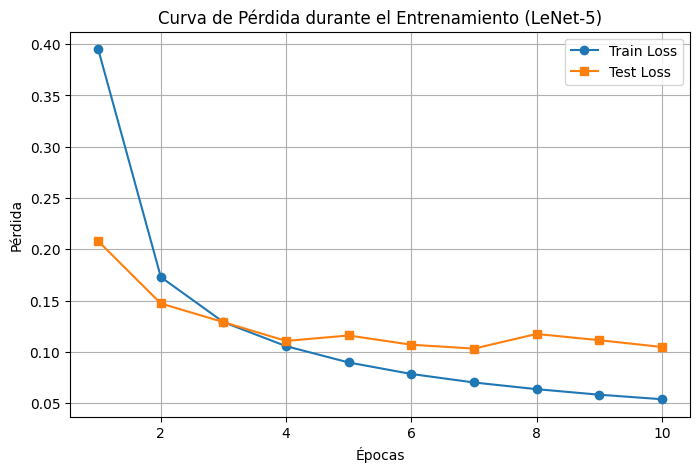

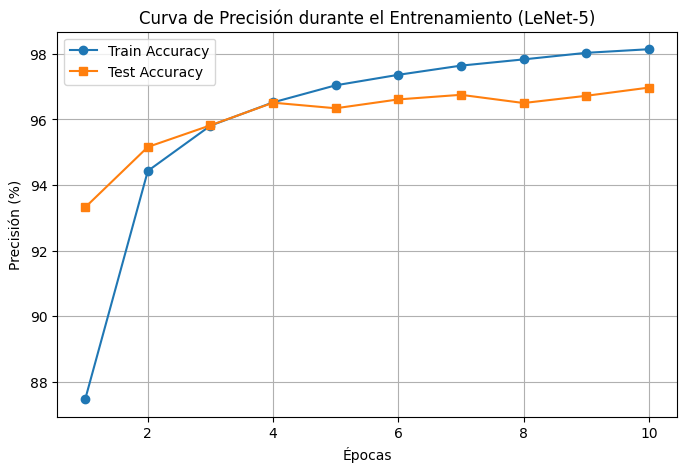

In [1]:
import matplotlib.pyplot as plt

#Datos de LeNet5

# Datos extraídos del texto del usuario
epochs = list(range(1, 11))
train_loss = [0.3950, 0.1730, 0.1291, 0.1057, 0.0898, 0.0786, 0.0703, 0.0638, 0.0584, 0.0540]
train_acc = [87.47, 94.43, 95.81, 96.52, 97.04, 97.36, 97.64, 97.83, 98.03, 98.14]
test_loss = [0.2080, 0.1473, 0.1291, 0.1108, 0.1161, 0.1071, 0.1033, 0.1176, 0.1115, 0.1049]
test_acc = [93.32, 95.16, 95.82, 96.51, 96.34, 96.61, 96.75, 96.50, 96.72, 96.97]

# Gráfico de Pérdida
plt.figure(figsize=(8,5))
plt.plot(epochs, train_loss, marker='o', label='Train Loss')
plt.plot(epochs, test_loss, marker='s', label='Test Loss')
plt.title("Curva de Pérdida durante el Entrenamiento (LeNet-5)")
plt.xlabel("Épocas")
plt.ylabel("Pérdida")
plt.legend()
plt.grid(True)
plt.show()

# Gráfico de Precisión
plt.figure(figsize=(8,5))
plt.plot(epochs, train_acc, marker='o', label='Train Accuracy')
plt.plot(epochs, test_acc, marker='s', label='Test Accuracy')
plt.title("Curva de Precisión durante el Entrenamiento (LeNet-5)")
plt.xlabel("Épocas")
plt.ylabel("Precisión (%)")
plt.legend()
plt.grid(True)
plt.show()


## Descargar el dataset EMNIST

In [10]:
import torchvision

# Download the EMNIST dataset
emnist_train_dataset = torchvision.datasets.EMNIST(root='./data', split='mnist', train=True, download=True, transform=transforms.ToTensor())
emnist_test_dataset = torchvision.datasets.EMNIST(root='./data', split='mnist', train=False, download=True, transform=transforms.ToTensor())

print("EMNIST dataset downloaded.")

100%|██████████| 562M/562M [00:07<00:00, 72.9MB/s]


EMNIST dataset downloaded.


## Crear DataLoaders para EMNIST

In [27]:
from torch.utils.data import DataLoader

emnist_train_loader = DataLoader(emnist_train_dataset, batch_size=64, shuffle=True, num_workers=2)
emnist_test_loader = DataLoader(emnist_test_dataset, batch_size=64, shuffle=False, num_workers=2)

print("EMNIST DataLoaders created.")

EMNIST DataLoaders created.


## Entrenar y evaluar CNNModelA en EMNIST

In [28]:
print("Entrenamiento Modelo CNN 3 bloques en EMNIST")
model_a_emnist = CNNModelA()
history_a_emnist, test_loss_a_emnist, test_acc_a_emnist = train_and_evaluate_with_history(model_a_emnist, emnist_train_loader, emnist_test_loader, device, epochs=5)

Entrenamiento Modelo CNN 3 bloques en EMNIST
Epoch 1/5 - Train Loss: 0.1171 - Train Acc: 96.30% - Test Loss: 0.0372 - Test Acc: 98.84%
Epoch 2/5 - Train Loss: 0.0342 - Train Acc: 98.97% - Test Loss: 0.0267 - Test Acc: 99.13%
Epoch 3/5 - Train Loss: 0.0240 - Train Acc: 99.28% - Test Loss: 0.0289 - Test Acc: 99.01%
Epoch 4/5 - Train Loss: 0.0180 - Train Acc: 99.46% - Test Loss: 0.0270 - Test Acc: 99.22%
Epoch 5/5 - Train Loss: 0.0140 - Train Acc: 99.59% - Test Loss: 0.0390 - Test Acc: 98.99%


## Resultados en EMNIST

In [29]:
print(f"CNNModelA en EMNIST: Test Loss = {test_loss_a_emnist:.4f}, Test Accuracy = {test_acc_a_emnist:.4f}")

CNNModelA en EMNIST: Test Loss = 0.0390, Test Accuracy = 98.9900


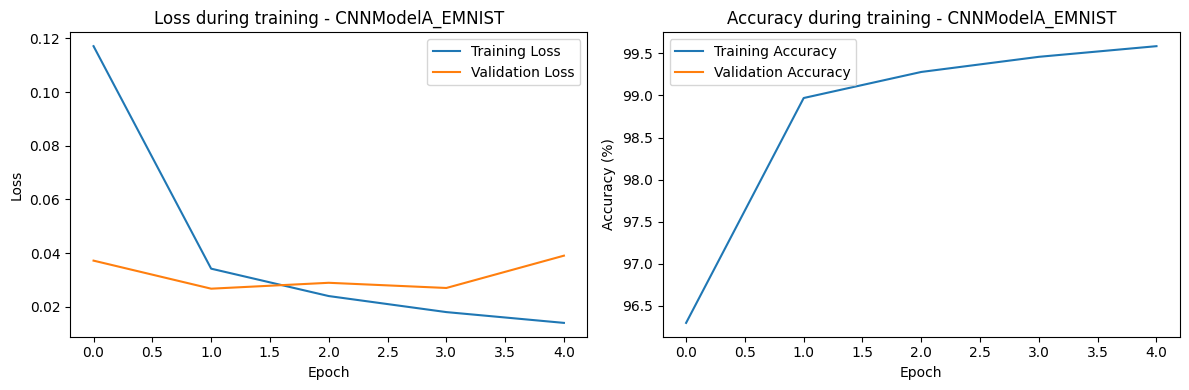

In [30]:
import matplotlib.pyplot as plt

# Plot history for CNNModelA_EMNIST
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_a_emnist['train_loss'], label='Training Loss')
plt.plot(history_a_emnist['test_loss'],  label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss during training - CNNModelA_EMNIST')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_a_emnist['train_acc'], label='Training Accuracy')
plt.plot(history_a_emnist['test_acc'],  label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy during training - CNNModelA_EMNIST')
plt.legend()

plt.tight_layout()
plt.show()